In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Functions

In [2]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov(cdist(x, X)) @ np.linalg.solve(sigma, Y)

In [3]:
def nestedKriging(x, X, Y, A, cov):
    '''
    x : prediction point
    X : the vector of all observation points
    Y : all observations
    A : list of list with submodels indexes
    cov : covariance function cov(h) 
    '''
    M = np.zeros((len(A),1))
    k_M = np.zeros((len(A),1))
    K_M = np.zeros((len(A),len(A)))

    for i in range(len(A)):
        k_x_X_i = np.nan_to_num(cov(cdist(x, X[A[i],:])), nan=1)
        k_X_X_i = np.nan_to_num(cov(cdist(X[A[i],:], X[A[i],:])), nan=1)
        
        M[i] = k_x_X_i @ np.linalg.solve(k_X_X_i, Y[A[i]])
        k_M[i] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        
        for j in range(i+1, len(A)):
            k_x_X_j = np.nan_to_num(cov(cdist(x, X[A[j],:])), nan=1)
            k_X_X_j = np.nan_to_num(cov(cdist(X[A[j],:], X[A[j],:])), nan=1)
            k_X_i_X_j = np.nan_to_num(cov(cdist(X[A[i],:], X[A[j],:])), nan=1)
            
            K_M[i,j] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)    
    
    K_M = K_M + K_M.T
    np.fill_diagonal(K_M, k_M)
    
    return k_M.T @ np.linalg.solve(K_M, M)

In [4]:
def scatterplot(X,Y,title='',xlabel='',ylabel=''):
    plt.scatter(X,Y)
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], [min(min(X), min(Y)), max(max(X), max(Y))], ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

Matérn con $K_\nu$

In [5]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

Observation points

In [6]:
d = 2
n = 500
sup = 20
X = np.random.uniform(0, sup, (n,d))

Parameters

In [7]:
nu = 3/2
theta = 1

Models

In [8]:
cov = matern_model(theta, nu)

In [9]:
sigma = np.nan_to_num(cov(cdist(X, X)), nan=1)

In [10]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, n)

In [18]:
X = np.arange(0.1, 1, 0.2).reshape((5,1))
cov = lambda h : np.exp(-12.5*h**2) 
sigma = np.nan_to_num(cov(cdist(X, X)), nan=1)

In [19]:
f = lambda x : np.sin(2 * np.pi * x) + x
Y = f(X)

X_aux_graph = np.linspace(-0.2,1.2,50).reshape((50,1))
Y_aux_graph = f(X_aux_graph)

In [20]:
A = [[0,1,2], [3,4]]

In [21]:
sigma[A[0]][:, A[0]]

array([[1.        , 0.60653066, 0.13533528],
       [0.60653066, 1.        , 0.60653066],
       [0.13533528, 0.60653066, 1.        ]])

In [22]:
X[A[0]] # X_1

array([[0.1],
       [0.3],
       [0.5]])

In [23]:
Y_K = kriging(X_aux_graph, X, Y, sigma, cov)
Y_K_1 = kriging(X_aux_graph, X[A[0]], Y[A[0]], sigma[A[0]][:, A[0]], cov)
Y_K_2 = kriging(X_aux_graph, X[A[1]], Y[A[1]], sigma[A[1]][:, A[1]], cov)

In [24]:
Y_NK = np.array([nestedKriging(X_aux_graph[[i]], X, Y, A, cov)[0] for i in range(len(X_aux_graph))])

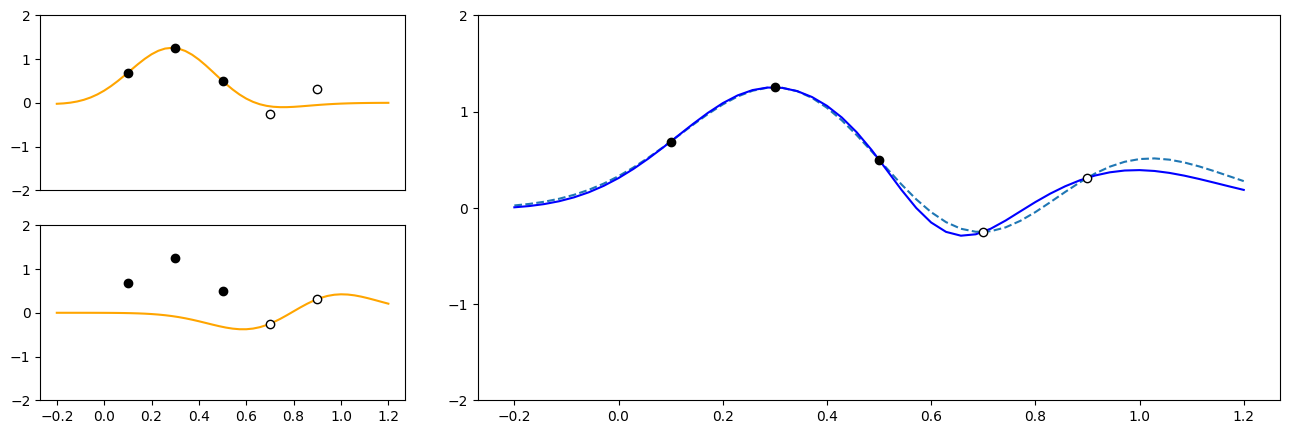

In [25]:
fig = plt.figure(figsize=(16, 5))
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (0, 1), rowspan=2, colspan=2)

ticks = np.arange(-2,3)

ax1.plot(X_aux_graph, Y_K_1, c='orange')
ax1.scatter(X[A[0],:], Y[A[0]], c='k', zorder=3)
ax1.scatter(X[A[1],:], Y[A[1]], c='w', edgecolors='k', zorder=3)
ax1.set_xticks([])
ax1.set_yticks(ticks)

ax2.plot(X_aux_graph, Y_K_2, c='orange')
ax2.scatter(X[A[0],:], Y[A[0]], c='k', zorder=3)
ax2.scatter(X[A[1],:], Y[A[1]], c='w', edgecolors='k', zorder=3)
ax2.set_yticks(ticks)

ax3.plot(X_aux_graph, Y_K, ls='--')
ax3.plot(X_aux_graph, Y_NK, c='b')

ax3.scatter(X[A[0],:], Y[A[0]], c='k', zorder=3)
ax3.scatter(X[A[1],:], Y[A[1]], c='w', edgecolors='k', zorder=3)
ax3.set_yticks(ticks)

plt.show()

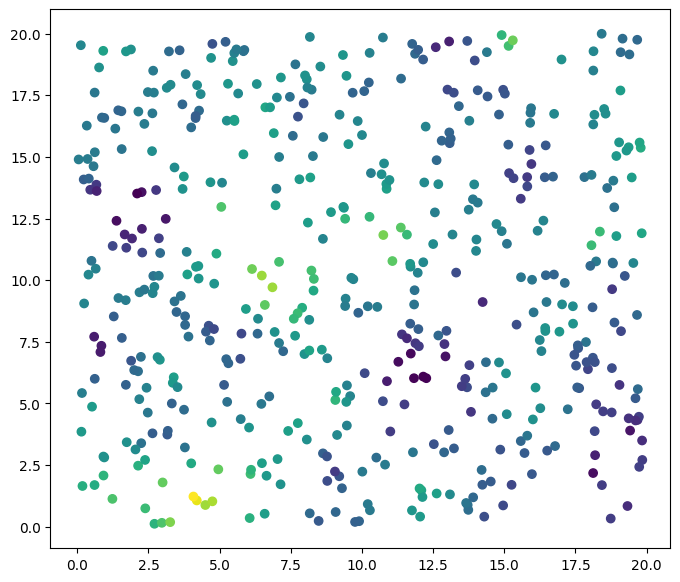

In [11]:
plt.figure(figsize=(8,7))
plt.scatter(X[:,0], X[:,1], c=Y);

In [16]:
def leave_one_out_univariate(X, Y, cov):
    
    n_points = (len(X)-1)//5
    A = np.arange((len(X)-1)//n_points*n_points)
    np.random.shuffle(A)
    A = A.reshape(((len(X)-1)//n_points,n_points))  
    
    Y_pred = []
    for i in range(0, X.shape[0]):
        X_aux = np.delete(X, i, axis=0)
        Y_aux = np.delete(Y, i, axis=0)
        Y_pred.append(nestedKriging(X[[i]], X_aux, Y_aux, A, cov))
    return np.array(Y_pred).reshape(-1)

In [13]:
def leave_one_out_univariate_kriging(X, Y, sigma, cov):
    Y_pred = []
    for i in range(0, X.shape[0]):
        sigma_aux = np.delete(np.delete(sigma, i, axis=0), i, axis=1)
        X_aux = np.delete(X, i, axis=0)
        Y_aux = np.delete(Y, i, axis=0)
        Y_pred.append(kriging(X[[i]], X_aux, Y_aux, sigma_aux, cov))
    return np.array(Y_pred).reshape(-1)

RMSE = 0.2539983000640833


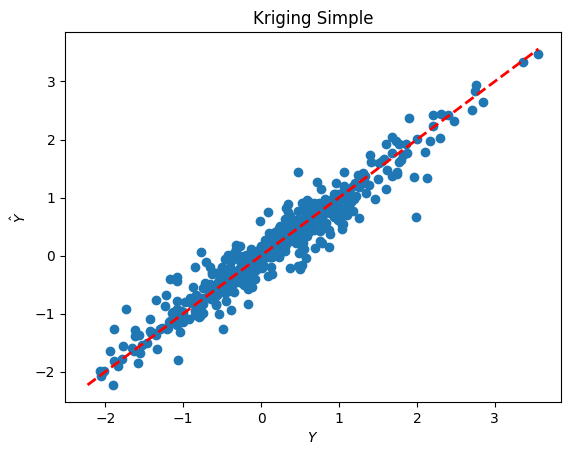

In [14]:
Y_pred_K = leave_one_out_univariate_kriging(X, Y, sigma, cov)

RMSE = root_mean_squared_error(Y, Y_pred_K)
print(f'{RMSE = }')

scatterplot(Y, Y_pred_K, title=r'Kriging Simple', xlabel=r'$Y$', ylabel=r'$\hat{Y}$')

RMSE = 0.2881013197763928


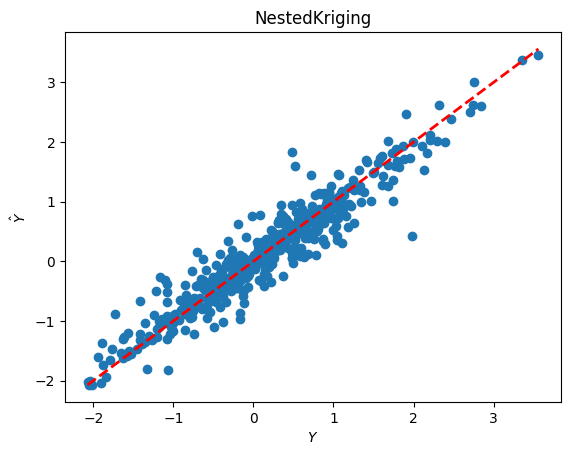

In [17]:
Y_pred_NK = leave_one_out_univariate(X, Y, cov)

RMSE = root_mean_squared_error(Y, Y_pred_NK)
print(f'{RMSE = }')

scatterplot(Y.reshape(-1), Y_pred_NK, title=r'NestedKriging', xlabel=r'$Y$', ylabel=r'$\hat{Y}$')

In [ ]:
plt.figure(figsize=(8,7))
plt.scatter(X, Y, label = 'Observations')
plt.scatter(X, Y_pred_NK, label = 'NestedKriging')
plt.scatter(X, Y_pred_K, label = 'Kriging')
plt.legend();